<a href="https://colab.research.google.com/github/alessioborgi/RL_Project/blob/main/X_GNN_MUTAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# X-GNN: Model-Explanations of GNNs using RL

### *Alessio Borgi*
### *Francesco Danese*

### 0: INTALLING & IMPORTING LIBRARIES

In [1]:
!pip install torch_geometric networkx matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00


In [2]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import networkx as nx
from torch.nn import Linear
import plotly.express as px
import matplotlib.pyplot as plt
import torch.nn.functional as F
import plotly.graph_objects as go
from torch_geometric.nn import MessagePassing
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx, to_dense_adj
from torch_geometric.utils import add_self_loops, remove_self_loops, degree

In [3]:
# Ensures that dataset splitting, model initialization, and training are deterministic.
def set_seed(seed):
    torch.manual_seed(seed)  # Fix seed for PyTorch (CPU).
    torch.cuda.manual_seed(seed)  # Fix seed for PyTorch (GPU).
    torch.cuda.manual_seed_all(seed)  # Fix seed for all GPUs.
    np.random.seed(seed)  # Fix seed for NumPy.
    random.seed(seed)  # Fix seed for Python's random module.
    torch.backends.cudnn.deterministic = True  # Ensure deterministic GPU behavior.
    torch.backends.cudnn.benchmark = False  # Disable cuDNN auto-tuning to enforce determinism.

set_seed(42)  # Set seed to ensure reproducibility across runs.

### 1: DATASET EXPLORATION

In [4]:
# Load the MUTAG Dataset.
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [5]:
# Initialize lists to collect dataset-wide statistics.
num_nodes = []
num_edges = []
labels = []

# Gather data about all graphs.
for data in dataset:
    num_nodes.append(data.num_nodes)
    num_edges.append(data.num_edges)
    labels.append(data.y.item())

# Create a summary DataFrame.
df = pd.DataFrame({
    "Graph ID": range(len(dataset)),
    "Num Nodes": num_nodes,
    "Num Edges": num_edges,
    "Label": labels
})

# Dataset Statistics.
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f"Number of Graphs: {len(dataset)}")
print(f"Number of Classes: {dataset.num_classes}")
print(f"Average Nodes per Graph: {sum(num_nodes)/len(num_nodes):.2f}")
print(f"Average Edges per Graph: {sum(num_edges)/len(num_edges):.2f}")
print("Class Distribution:")
print(df['Label'].value_counts())


Dataset: MUTAG(188):
Number of Graphs: 188
Number of Classes: 2
Average Nodes per Graph: 17.93
Average Edges per Graph: 39.59
Class Distribution:
Label
1    125
0     63
Name: count, dtype: int64


In [6]:
# Plot class distribution using Plotly.
class_counts = df['Label'].value_counts().reset_index()
class_counts.columns = ['Label', 'Count']

fig = px.bar(
    class_counts,
    x='Label', y='Count',
    labels={"Label": "Class Label", "Count": "Count"},
    title="Class Distribution in MUTAG Dataset"
)
fig.show()


In [7]:
# Take the first graph of the Dataset.
single_graph = dataset[0]
print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {single_graph.num_nodes}')
print(f'Number of edges: {single_graph.num_edges}')
print(f'Average node degree: {single_graph.num_edges / single_graph.num_nodes:.2f}')
print(f'Has isolated nodes: {single_graph.has_isolated_nodes()}')
print(f'Has self-loops: {single_graph.has_self_loops()}')
print(f'Is undirected: {single_graph.is_undirected()}')


Data(edge_index=[2, 36], x=[16, 7], edge_attr=[36, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [8]:
# Convert the first graph in the dataset to NetworkX.
G = to_networkx(single_graph, to_undirected=True)

# Generate 2D and 3D layouts.
pos_2d = nx.spring_layout(G)
pos_3d = nx.spring_layout(G, dim=3)

# Prepare edge trace for 2D visualization.
edge_x_2d = []
edge_y_2d = []
for edge in G.edges():
    x0, y0 = pos_2d[edge[0]]
    x1, y1 = pos_2d[edge[1]]
    edge_x_2d.extend([x0, x1, None])
    edge_y_2d.extend([y0, y1, None])

edge_trace_2d = go.Scatter(
    x=edge_x_2d, y=edge_y_2d,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Prepare node trace for 2D visualization.
node_x_2d = []
node_y_2d = []
node_labels = []
for node in G.nodes():
    x, y = pos_2d[node]
    node_x_2d.append(x)
    node_y_2d.append(y)
    node_labels.append(f"{node}")

node_trace_2d = go.Scatter(
    x=node_x_2d, y=node_y_2d,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Degree',
            xanchor='left',
            titleside='right'
        ),
        color=[dict(G.degree())[node] for node in G.nodes()]
    ),
    text=node_labels,
    textposition="top center"
)

# 2D Visualization.
fig_2d = go.Figure(data=[edge_trace_2d, node_trace_2d],
                    layout=go.Layout(
                        title="2D Visualization of Graph 0",
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
fig_2d.show()

# Analyze graph properties
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Is graph directed? {data.is_directed()}")
print(f"Graph label: {data.y}")

Number of nodes: 16
Number of edges: 36
Is graph directed? False
Graph label: tensor([0])


In [9]:
# Prepare edge trace for 3D visualization
edge_x_3d = []
edge_y_3d = []
edge_z_3d = []
for edge in G.edges():
    x0, y0, z0 = pos_3d[edge[0]]
    x1, y1, z1 = pos_3d[edge[1]]
    edge_x_3d.extend([x0, x1, None])
    edge_y_3d.extend([y0, y1, None])
    edge_z_3d.extend([z0, z1, None])

edge_trace_3d = go.Scatter3d(
    x=edge_x_3d, y=edge_y_3d, z=edge_z_3d,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Prepare node trace for 3D visualization
node_x_3d = []
node_y_3d = []
node_z_3d = []
for node in G.nodes():
    x, y, z = pos_3d[node]
    node_x_3d.append(x)
    node_y_3d.append(y)
    node_z_3d.append(z)

node_trace_3d = go.Scatter3d(
    x=node_x_3d, y=node_y_3d, z=node_z_3d,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        size=10,
        color=[dict(G.degree())[node] for node in G.nodes()],
        colorscale='YlGnBu',
        colorbar=dict(
            thickness=15,
            title="Node Degree",
            xanchor='left',
            titleside='right'
        ),
    ),
    text=node_labels,
    textposition="top center"
)
# 3D Visualization
fig_3d = go.Figure(data=[edge_trace_3d, node_trace_3d],
                   layout=go.Layout(
                       title="3D Visualization of Graph 0",
                       showlegend=False,
                       margin=dict(b=0, l=0, r=0, t=40),
                       scene=dict(
                           xaxis=dict(showbackground=False),
                           yaxis=dict(showbackground=False),
                           zaxis=dict(showbackground=False)
                       )
                   ))
fig_3d.show()

# Analyze graph properties
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Is graph directed? {data.is_directed()}")
print(f"Graph label: {data.y}")


Number of nodes: 16
Number of edges: 36
Is graph directed? False
Graph label: tensor([0])


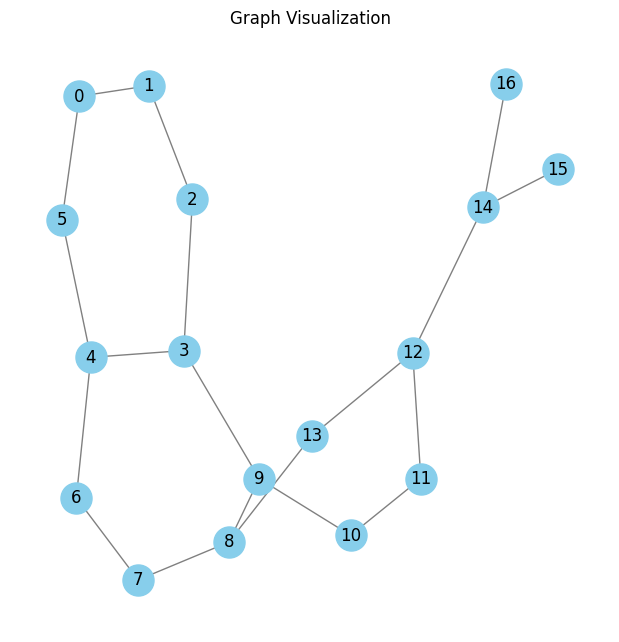

Number of nodes: 16
Number of edges: 36
Is graph directed? False
Graph label: tensor([0])


In [10]:
# Visualize the graph
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='grey')
plt.title("Graph Visualization")
plt.show()

# Analyze graph properties
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Is graph directed? {data.is_directed()}")
print(f"Graph label: {data.y}")

In [11]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


### PARTE DEL CINESE


In [12]:
import numpy as np
import scipy.sparse as sp
import torch


# MUTAG数据集特征，188个图，总共3371个结点，7442条边，为无向图

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)



def load_split_MUTAG_data(path="/content/datas/", dataset="MUTAG_", split_train=0.7, split_val=0.15):
    """Load MUTAG data """
    print('Loading {} dataset...'.format(dataset))

    # 加载图的标签
    graph_labels = np.genfromtxt("{}{}graph_labels.txt".format(path, dataset),
                           dtype=np.dtype(int))
    graph_labels = encode_onehot(graph_labels)  # (188, 2)
    graph_labels = torch.LongTensor(np.where(graph_labels)[1]) # (188, 1)


    # 图结点的索引号
    graph_idx = np.genfromtxt("{}{}graph_indicator.txt".format(path, dataset),
                              dtype=np.dtype(int))

    graph_idx = np.array(graph_idx, dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(graph_idx)} # key, value表示第key个图的起始结点索引号为value
    length = len(idx_map.keys()) # 总共有多少个图
    num_nodes = [idx_map[n] - idx_map[n - 1] if n - 1 > 1 else idx_map[n] for n in range(1, length + 1)] # 一个长度188的list，表示没个图有多少个结点
    max_num_nodes = max(num_nodes) # 最大的一个图有多少个结点
    features_list = []
    adj_list = []
    prev = 0

    # 结点的标签
    nodeidx_features = np.genfromtxt("{}{}node_labels.txt".format(path, dataset), delimiter=",",
                                     dtype=np.dtype(int))
    node_features = np.zeros((nodeidx_features.shape[0], max(nodeidx_features) + 1))
    node_features[np.arange(nodeidx_features.shape[0]), nodeidx_features] = 1

    # 边信息
    edges_unordered = np.genfromtxt("{}{}A.txt".format(path, dataset), delimiter=",",
                                    dtype=np.int32)

    # 边的标签
    edges_label = np.genfromtxt("{}{}edge_labels.txt".format(path, dataset), delimiter=",",
                                dtype=np.int32)  # shape = (7442,)

    # 生成邻接矩阵A，该邻接矩阵包括了数据集中所有的边
    adj = sp.coo_matrix((edges_label, (edges_unordered[:, 0] - 1, edges_unordered[:, 1] - 1)))

    # 论文里A^=(D~)^0.5 A~ (D~)^0.5这个公式
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    node_features = normalize(node_features)
    adj = normalize(adj + sp.eye(adj.shape[0])) # 对应公式A~=A+IN
    adj = adj.todense()

    for n in range(1, length + 1):
        # entry为第n个图的特征矩阵X
        entry = np.zeros((max_num_nodes, max(nodeidx_features) + 1))
        entry[:idx_map[n] - prev] = node_features[prev:idx_map[n]]
        entry = torch.FloatTensor(entry)
        features_list.append(entry.tolist())

        # entry为第n个图的邻接矩阵A
        entry = np.zeros((max_num_nodes, max_num_nodes))
        entry[:idx_map[n] - prev, :idx_map[n] - prev] = adj[prev:idx_map[n], prev:idx_map[n]]
        entry = torch.FloatTensor(entry)
        adj_list.append(entry.tolist())

        prev = idx_map[n] # prev为下个图起始结点的索引号

    num_total = max(graph_idx)
    num_train = int(split_train * num_total)
    num_val = int((split_train + split_val) * num_total)

    if (num_train == num_val or num_val == num_total):
        return

    features_list = torch.FloatTensor(features_list)
    adj_list = torch.FloatTensor(adj_list)

    idx_train = range(num_train)
    idx_val = range(num_train, num_val)
    idx_test = range(num_val, num_total)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    # 返回值一次为 188个图的邻接矩阵列表  188个图的特征矩阵列表  188个图的label， 每个图的起始结点索引号， 训练集索引号，
    # 验证集索引号， 测试集索引号
    return adj_list, features_list, graph_labels, idx_map, idx_train, idx_val, idx_test

### GNN MODEL

In [13]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter


class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    paper: Semi-Supervised Classification with Graph Convolutional Networks
    """
    # 模型的参数包括weight和bias
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    # 权重初始化
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    # 类似于tostring
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

    # 计算A~ X W(0)
    def forward(self, input, adj):
        # input.shape = [max_node, features] = X
        # adj.shape = [max_node, max_node] = A~
        # torch.mm(a, b)是矩阵a和b矩阵相乘，torch.mul(a, b)是矩阵a和b对应位相乘，a和b的维度必须相等
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output + self.bias


class GCN(nn.Module):
    # feature的个数；最终的分类数

    def __init__(self, nfeat, nclass, dropout):
        """ As per paper """
        """ 3 layers of GCNs with output dimensions equal to 32, 48, 64 respectively and average all node features """
        """ Final classifier with 2 fully connected layers and hidden dimension set to 32 """
        """ Activation function - ReLu (Mutag) """
        super(GCN, self).__init__()

        self.dropout = dropout

        self.gc1 = GraphConvolution(nfeat, 32)
        self.gc2 = GraphConvolution(32, 48)
        self.gc3 = GraphConvolution(48, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, nclass)

    def forward(self, x, adj):
        # x.shape = [max_node, features]
        # adj.shape = [max_node, max_node]
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc3(x, adj))


        y = torch.mean(x, 0)  # 采用mean作为聚合函数聚合所有结点的特征
        y = F.relu(self.fc1(y))
        y = F.dropout(y, self.dropout, training=self.training)
        y = F.softmax(self.fc2(y), dim=0)

        return y


if __name__ == '__main__':
    input = torch.rand(29, 7)
    adj = torch.rand(29, 29)

    model = GCN(nfeat=7,  # nfeat = 7
                nclass=2,  # nclass = 7
                dropout=0.1)

    output = model(input, adj)
    print(output.size())

torch.Size([2])


### GRAPH GENERATOR

In [14]:
import random
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


rollout = 10
MAX_NUM_NODES = 28 # for mutag
random.seed(200)

class Generator(nn.Module):
    def __init__(self, model_path: str, C: list, node_feature_dim: int ,num_class = 2, c=0, hyp1=1, hyp2=2, start=None, nfeat=7, dropout=0.1):
        """
        :param C: Candidate set of nodes (list)
        :param start: Starting node (defaults to randomised node)
        """
        super(Generator, self).__init__()
        self.nfeat = nfeat
        self.dropout = dropout
        self.c = c # c为要指定生成类别c的图

        self.fc = nn.Linear(nfeat, 8)
        self.gc1 = GraphConvolution(8, 16)
        self.gc2 = GraphConvolution(16, 24)
        self.gc3 = GraphConvolution(24, 32)

        # MLP1
        # 2 FC layers with hidden dimension 16
        self.mlp1 = nn.Sequential(nn.Linear(32, 16), nn.Linear(16, 1))

        # MLP2
        # 2 FC layers with hidden dimension 24
        self.mlp2 = nn.Sequential(nn.Linear(64, 24), nn.Linear(24, 1))

        # Hyperparameters
        self.hyp1 = hyp1
        self.hyp2 = hyp2
        self.candidate_set = C

        # Default starting node (if any)
        if start != None:
            self.start = start
            self.random_start = False
        else:
            self.start = random.choice(np.arange(0, len(self.candidate_set)))
            self.random_start = True

        # Load GCN for calculating reward
        self.model = GCN(nfeat=node_feature_dim,
                         nclass=num_class,
                         dropout=dropout)

        self.model.load_state_dict(torch.load(model_path))
        for param in self.model.parameters():
            param.requires_grad = False

        self.reset_graph()

    def reset_graph(self):
        """
        Reset g.G to default graph with only start node， 生成一个只有1个结点的图
        """
        if self.random_start == True:
            self.start = random.choice(np.arange(0, len(self.candidate_set)))

        # 初始图除了第1个结点全被mask，这里由于邻接矩阵的边长为MAX_NUM_NODES + len(self.candidate_set)，所以mask的不仅为候选集结点，还有图中的所以虚结点
        mask_start = torch.BoolTensor(
            [False if i == 0 else True for i in range(MAX_NUM_NODES + len(self.candidate_set))])

        adj = torch.zeros((MAX_NUM_NODES + len(self.candidate_set), MAX_NUM_NODES + len(self.candidate_set)),
                          dtype=torch.float32)   # 这里adj shape为 [MAX_NUM_NODES + len(self.candidate_set), MAX_NUM_NODES + len(self.candidate_set)] 中间可能有空结点

        feat = torch.zeros((MAX_NUM_NODES + len(self.candidate_set), len(self.candidate_set)), dtype=torch.float32)
        feat[0, self.start] = 1
        feat[np.arange(-len(self.candidate_set), 0), np.arange(0, len(self.candidate_set))] = 1

        degrees = torch.zeros(MAX_NUM_NODES)

        self.G = {'adj': adj, 'feat': feat, 'degrees': degrees, 'num_nodes': 1, 'mask_start': mask_start}

    ## 计算Gt->Gt+1
    def forward(self, G_in):
        ## G_in为 Gt
        G = copy.deepcopy(G_in)

        x = G['feat'].detach().clone() # Gt的特征矩阵
        adj = G['adj'].detach().clone() # Gt的邻接矩阵

        ## 对应 X = GCNs(Gt​,C)
        x = F.relu6(self.fc(x))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc3(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        ## pt,start​=Softmax(MLPs(X))
        p_start = self.mlp1(x)
        p_start = p_start.masked_fill(G['mask_start'].unsqueeze(1), 0)
        p_start = F.softmax(p_start, dim=0)
        a_start_idx = torch.argmax(p_start.masked_fill(G['mask_start'].unsqueeze(1), -1))

        ## pt,end​=Softmax(MLPs([X,x^start​))
        # broadcast
        x1, x2 = torch.broadcast_tensors(x, x[a_start_idx])
        x = torch.cat((x1, x2), 1)  # cat increases dim from 32 to 64

        # 计算maskt,end，除了候选集和Gt结点中未被选为初始结点的结点之外，其它均被mask
        mask_end = torch.BoolTensor([True for i in range(MAX_NUM_NODES + len(self.candidate_set))])
        mask_end[MAX_NUM_NODES:] = False
        mask_end[:G['num_nodes']] = False
        mask_end[a_start_idx] = True

        p_end = self.mlp2(x)
        p_end = p_end.masked_fill(mask_end.unsqueeze(1), 0)
        p_end = F.softmax(p_end, dim=0)
        a_end_idx = torch.argmax(p_end.masked_fill(mask_end.unsqueeze(1), -1))

        # Return new G
        # If a_end_idx is not masked, node exists in graph, no new node added
        if G['mask_start'][a_end_idx] == False:
            G['adj'][a_end_idx][a_start_idx] += 1
            G['adj'][a_start_idx][a_end_idx] += 1

            # Update degrees
            G['degrees'][a_start_idx] += 1
            G['degrees'][G['num_nodes']] += 1
        else:
            # Add node
            G['feat'][G['num_nodes']] = G['feat'][a_end_idx]
            # Add edge
            G['adj'][G['num_nodes']][a_start_idx] += 1
            G['adj'][a_start_idx][G['num_nodes']] += 1
            # Update degrees
            G['degrees'][a_start_idx] += 1
            G['degrees'][G['num_nodes']] += 1

            # Update start mask
            G_mask_start_copy = G['mask_start'].detach().clone()
            G_mask_start_copy[G['num_nodes']] = False
            G['mask_start'] = G_mask_start_copy

            G['num_nodes'] += 1

        return p_start, a_start_idx, p_end, a_end_idx, G


    ### reward函数
    def calculate_reward(self, G_t_1):
        """
        Rtr     Calculated from graph rules to encourage generated graphs to be valid
                1. Only one edge to be added between any two nodes
                2. Generated graph cannot contain more nodes than predefined maximum node number
                3. (For chemical) Degree cannot exceed valency
                If generated graph violates graph rule, Rtr = -1

        Rtf     Feedback from trained model
        """

        rtr = self.check_graph_rules(G_t_1)

        rtf = self.calculate_reward_feedback(G_t_1)
        rtf_sum = 0
        for m in range(rollout):
            p_start, a_start, p_end, a_end, G_t_1 = self.forward(G_t_1)
            rtf_sum += self.calculate_reward_feedback(G_t_1)
        rtf = rtf + rtf_sum * self.hyp1 / rollout

        return rtf + self.hyp2 * rtr

    def calculate_reward_feedback(self, G_t_1):
        """
        p(f(G_t_1) = c) - 1/l
        where l denotes number of possible classes for f
        """
        f = self.model(G_t_1['feat'], G_t_1['adj'])
        return f[self.c] - 1 / len(f)


    ## graph rules
    def check_graph_rules(self, G_t_1):
        """
        For mutag, node degrees cannot exceed valency
        """
        idx = 0

        for d in G_t_1['degrees']:
            if d != 0:
                node_id = torch.argmax(G_t_1['feat'][idx])  # Eg. [0, 1, 0, 0] -> 1
                node = self.candidate_set[node_id]  # Eg ['C.4', 'F.2', 'Br.7'][1] = 'F.2'
                max_valency = int(node.split('.')[1])  # Eg. C.4 -> ['C', '4'] -> 4

                # If any node degree exceeds its valency, return -1
                if max_valency < d:
                    return -1

        return 0


    ## 计算loss
    def calculate_loss(self, Rt, p_start, a_start, p_end, a_end, G_t_1):
        """
        Calculated from cross entropy loss (Lce) and reward function (Rt)
        where loss = -Rt*(Lce_start + Lce_end)
        """

        Lce_start = F.cross_entropy(torch.reshape(p_start, (1, 35)), a_start.unsqueeze(0))
        Lce_end = F.cross_entropy(torch.reshape(p_end, (1, 35)), a_end.unsqueeze(0))

        return -Rt * (Lce_start + Lce_end)

### CHECK

In [16]:
import numpy as np
import scipy.sparse as sp

import torch

src_path = '/content/datas/MUTAG_{}'
split_train=0.7
split_val=0.15

if __name__ == '__main__':
    nodeidx_features = np.genfromtxt(src_path.format('node_labels.txt'), delimiter=",",
                                     dtype=np.dtype(int))
    node_features = np.zeros((nodeidx_features.shape[0], max(nodeidx_features) + 1))
    node_features[np.arange(nodeidx_features.shape[0]), nodeidx_features] = 1


    graph_labels = np.genfromtxt(src_path.format('graph_labels.txt'), dtype=np.dtype(int))
    graph_labels = encode_onehot(graph_labels)
    graph_labels = torch.LongTensor(np.where(graph_labels)[1])


    graph_idx = np.genfromtxt(src_path.format('graph_indicator.txt'),dtype=np.dtype(int))
    graph_idx = np.array(graph_idx, dtype=np.int32)


    edges_unordered = np.genfromtxt(src_path.format('A.txt'), delimiter=",",
                                    dtype=np.int32)  # (7442,2)

    edges_label = np.genfromtxt(src_path.format('edge_labels.txt'), delimiter=",",
                                dtype=np.int32)

    # 邻接矩阵
    adj = sp.coo_matrix((edges_label, (edges_unordered[:, 0] - 1, edges_unordered[:, 1] - 1)))
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj) # (3371, 3371)

    idx_map = {j: i for i, j in enumerate(graph_idx)} # key, value表示第key个图的起始结点索引号为value
    length = len(idx_map.keys())  # 总共有多少个图 , 188
    num_nodes = [idx_map[n] - idx_map[n - 1] if n - 1 > 1 else idx_map[n] for n in range(1, length + 1)]  # 一个长度188的list，表示没个图有多少个结点
    max_num_nodes = max(num_nodes) # 最大的一个图有多少个结点 实际29
    features_list = []
    adj_list = []
    prev = 0

    node_features = normalize(node_features) # (3371, 7)
    adj = normalize(adj + sp.eye(adj.shape[0]))
    adj = adj.todense()

    for n in range(1, length + 1):
        # entry为图的特征矩阵X
        entry = np.zeros((max_num_nodes, max(nodeidx_features) + 1))
        entry[:idx_map[n] - prev] = node_features[prev:idx_map[n]]
        entry = torch.FloatTensor(entry)
        features_list.append(entry)

        # entry为图的邻接矩阵A
        entry = np.zeros((max_num_nodes, max_num_nodes))
        entry[:idx_map[n] - prev, :idx_map[n] - prev] = adj[prev:idx_map[n], prev:idx_map[n]]
        entry = torch.FloatTensor(entry)
        adj_list.append(entry)

        prev = idx_map[n] # prev为下个图起始结点的索引号

    num_total = max(graph_idx)
    num_train = int(split_train * num_total)
    num_val = int((split_train + split_val) * num_total)

    idx_train = range(num_train)
    idx_val = range(num_train, num_val)
    idx_test = range(num_val, num_total)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)


    print(graph_labels[idx_train])
    print(graph_labels[idx_val])

tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1])
tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0])


### TRAINING


In [18]:
import time

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

model_path = 'model/gcn_first.pth'

epochs = 1000
seed = 200
lr = 0.001
dropout = 0.1
weight_decay = 5e-4

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


class EarlyStopping():
    def __init__(self, patience=10, min_loss=0.5, hit_min_before_stopping=False):
        self.patience = patience
        self.counter = 0
        self.hit_min_before_stopping = hit_min_before_stopping
        if hit_min_before_stopping:
            self.min_loss = min_loss
        self.best_loss = None
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss:
            self.counter += 1
            if self.counter > self.patience:
                if self.hit_min_before_stopping == True and loss > self.min_loss:
                    print("Cannot hit mean loss, will continue")
                    self.counter -= self.patience
                else:
                    self.early_stop = True
        else:
            self.best_loss = loss
            counter = 0


if __name__ == '__main__':
    # adj_list: [188, 29, 29]
    # features_list: [188, 29, 7]
    # graph_labels: [188]
    adj_list, features_list, graph_labels, idx_map, idx_train, idx_val, idx_test = load_split_MUTAG_data()
    idx_train = torch.cat([idx_train, idx_val, idx_test])

    model = GCN(nfeat=features_list[0].shape[1], # nfeat = 7
                nclass=graph_labels.max().item() + 1, # nclass = 2
                dropout=dropout)
    optimizer = optim.Adam(model.parameters(),
                           lr=lr, weight_decay=weight_decay)

    model.cuda()
    features_list = features_list.cuda()
    adj_list = adj_list.cuda()
    graph_labels = graph_labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

    # 训练模型
    early_stopping = EarlyStopping(10, hit_min_before_stopping=True)
    t_total = time.time()

    for epoch in range(epochs):
        t = time.time()
        model.train()
        optimizer.zero_grad()

        # # Split
        outputs = []
        for i in idx_train:
            output = model(features_list[i], adj_list[i])
            output = output.unsqueeze(0)
            outputs.append(output)
        output = torch.cat(outputs, dim=0)


        loss_train = F.cross_entropy(output, graph_labels[idx_train])
        acc_train = accuracy(output, graph_labels[idx_train])
        loss_train.backward()
        optimizer.step()

        model.eval()
        outputs = []
        for i in idx_val:
            output = model(features_list[i], adj_list[i])
            output = output.unsqueeze(0)
            outputs.append(output)
        output = torch.cat(outputs, dim=0)
        loss_val = F.cross_entropy(output, graph_labels[idx_val])
        acc_val = accuracy(output, graph_labels[idx_val])

        print('Epoch: {:04d}'.format(epoch + 1),
              'loss_train: {:.4f}'.format(loss_train.item()),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'acc_val: {:.4f}'.format(acc_val.item()),
              'time: {:.4f}s'.format(time.time() - t))

        print(loss_val)
        early_stopping(loss_val)
        if early_stopping.early_stop == True:
            break

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

    torch.save(model.state_dict(), model_path)

Loading MUTAG_ dataset...
Epoch: 0001 loss_train: 0.7084 acc_train: 0.3351 loss_val: 0.6937 acc_val: 0.5000 time: 0.2765s
tensor(0.6937, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch: 0002 loss_train: 0.7074 acc_train: 0.3351 loss_val: 0.6933 acc_val: 0.5000 time: 0.2643s
tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch: 0003 loss_train: 0.7053 acc_train: 0.3351 loss_val: 0.6930 acc_val: 0.5000 time: 0.2761s
tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch: 0004 loss_train: 0.7025 acc_train: 0.3351 loss_val: 0.6928 acc_val: 0.5000 time: 0.2552s
tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch: 0005 loss_train: 0.7015 acc_train: 0.3351 loss_val: 0.6925 acc_val: 0.5000 time: 0.2628s
tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch: 0006 loss_train: 0.7004 acc_train: 0.3351 loss_val: 0.6923 acc_val: 0.5000 time: 0.3963s
tensor(0.6923, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch: 0007 loss_train: 0.6984 acc_tra

### TRAINING GENERATOR

In [19]:
import copy

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

lr = 0.01
b1 = 0.9
b2 = 0.99
hyp1 = 1
hyp2 = 2
max_gen_step = 10  # T = 10

candidate_set = ['C.4', 'N.5', 'O.2', 'F.1', 'I.7', 'Cl.7', 'Br.5']  # C.4表明碳原子的度不超过4
model_path = 'model/gcn_first.pth'

## 训练generator
def train_generator(c=0, max_nodes=5):
    g.c = c
    for i in range(max_gen_step):
        optimizer.zero_grad()
        G = copy.deepcopy(g.G)
        p_start, a_start, p_end, a_end, G = g.forward(G)

        Rt = g.calculate_reward(G)
        loss = g.calculate_loss(Rt, p_start, a_start, p_end, a_end, G)
        loss.backward()
        optimizer.step()

        if G['num_nodes'] > max_nodes:
            g.reset_graph()
        elif Rt > 0:
            g.G = G


## 生成图
def generate_graph(c=0, max_nodes=5):
    g.c = c
    g.reset_graph()

    for i in range(max_gen_step):
        G = copy.deepcopy(g.G)
        p_start, a_start, p_end, a_end, G = g.forward(G)
        Rt = g.calculate_reward(G)

        if G['num_nodes'] > max_nodes:
            return g.G
        elif Rt > 0:
            g.G = G

    return g.G

## 画图
def display_graph(G):
    G_nx = nx.from_numpy_matrix(np.asmatrix(G['adj'][:G['num_nodes'], :G['num_nodes']].numpy()))
    # nx.draw_networkx(G_nx)

    layout=nx.spring_layout(G_nx)
    nx.draw(G_nx, layout)

    coloring=torch.argmax(G['feat'],1)
    colors=['b','g','r','c','m','y','k']

    for i in range(7):
        nx.draw_networkx_nodes(G_nx,pos=layout,nodelist=[x for x in G_nx.nodes() if coloring[x]==i],node_color=colors[i])
        nx.draw_networkx_labels(G_nx,pos=layout,labels={x:candidate_set[i].split('.')[0] for x in G_nx.nodes() if coloring[x]==i})
    nx.draw_networkx_edges(G_nx,pos=layout,width=list(nx.get_edge_attributes(G_nx,'weight').values()))
    nx.draw_networkx_edge_labels(G_nx,pos=layout,edge_labels=nx.get_edge_attributes(G_nx, "weight"))

    plt.show()

if __name__ == '__main__':
    g = Generator(model_path = model_path, C = candidate_set, node_feature_dim=7 ,c=0, start=0)
    optimizer = optim.Adam(g.parameters(), lr=lr, betas=(b1, b2))

    for i in range(1, 10):
        ## 生成最多分别包括i个结点的图结构
        g.reset_graph()
        train_generator(c=1, max_nodes=i)
        to_display = generate_graph(c=1, max_nodes=i)
        display_graph(to_display)
        print(g.model(to_display['feat'], to_display['adj']))

<ipython-input-14-c93076f51218>:56: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



AttributeError: module 'networkx' has no attribute 'from_numpy_matrix'

### TEST

In [20]:
from Load_dataset import load_split_MUTAG_data, accuracy
from Model import GCN
import time

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

model_path = 'model/gcn_first.pth'

if __name__ == '__main__':
    adj_list, features_list, graph_labels, idx_map, idx_train, idx_val, idx_test = load_split_MUTAG_data()
    model = GCN(nfeat=features_list[0].shape[1],  # nfeat = 7
                nclass=graph_labels.max().item() + 1,  # nclass = 2
                dropout=0.1)

    model.eval()
    outputs = []
    for i in idx_test:
        output = model(features_list[i], adj_list[i])
        output = output.unsqueeze(0)
        outputs.append(output)
    output = torch.cat(outputs, dim=0)

    loss_test = F.cross_entropy(output, graph_labels[idx_test])
    acc_test = accuracy(output, graph_labels[idx_test])
    print(loss_test)
    print(acc_test)

ModuleNotFoundError: No module named 'Load_dataset'